# DeltaIoTv1

In [2]:
from code_base.analysis import *
from code_base.model import *
from code_base.simulation import *
from code_base.solution import *
from code_base.visualization import *

In [3]:
folder_path = 'data/log'

## Data loading

In [ ]:
df = construct_cycle_df(folder_path, cycle=3)
print(len(df))
df.head(5)

216


,energyconsumption,packetloss,latency,link0_distribution,link1_distribution,link2_distribution,link3_distribution,link4_distribution,link5_distribution,link6_distribution,link7_distribution,link8_distribution,link9_distribution,link10_distribution,link11_distribution,link12_distribution,link13_distribution,link14_distribution,link15_distribution,link16_distribution,env_EC,env_PL,env_LA,env_link_power,env_link_dist,env_mote_trafficload,env_link_SNR
0,12.7040,7.857885,0.0,100,100,100,100,100,0,100,100,100,0,100,100,0,100,100,100,100,16.204002,1.935484,0.012658,"[0, 7, 15, 15, 15, 13, 15, 9, 15, 15, 15, 11, ...","[100, 100, 100, 100, 100, 0, 100, 100, 100, 0,...","[50, 100, 50, 50, 100, 50, 50, 100, 0, 50, 50,...","[2.635660385796415, -0.037739614203585, -0.473..."
1,12.7190,7.673685,0.0,100,100,100,100,100,20,80,100,100,0,100,100,0,100,100,100,100,16.204002,1.935484,0.012658,"[0, 7, 15, 15, 15, 13, 15, 9, 15, 15, 15, 11, ...","[100, 100, 100, 100, 100, 0, 100, 100, 100, 0,...","[50, 100, 50, 50, 100, 50, 50, 100, 0, 50, 50,...","[2.635660385796415, -0.037739614203585, -0.473..."
2,12.7341,7.457315,0.0,100,100,100,100,100,40,60,100,100,0,100,100,0,100,100,100,100,16.204002,1.935484,0.012658,"[0, 7, 15, 15, 15, 13, 15, 9, 15, 15, 15, 11, ...","[100, 100, 100, 100, 100, 0, 100, 100, 100, 0,...","[50, 100, 50, 50, 100, 50, 50, 100, 0, 50, 50,...","[2.635660385796415, -0.037739614203585, -0.473..."
3,12.7491,7.237425,0.0,100,100,100,100,100,60,40,100,100,0,100,100,0,100,100,100,100,16.204002,1.935484,0.012658,"[0, 7, 15, 15, 15, 13, 15, 9, 15, 15, 15, 11, ...","[100, 100, 100, 100, 100, 0, 100, 100, 100, 0,...","[50, 100, 50, 50, 100, 50, 50, 100, 0, 50, 50,...","[2.635660385796415, -0.037739614203585, -0.473..."
4,12.7642,7.321725,0.0,100,100,100,100,100,80,20,100,100,0,100,100,0,100,100,100,100,16.204002,1.935484,0.012658,"[0, 7, 15, 15, 15, 13, 15, 9, 15, 15, 15, 11, ...","[100, 100, 100, 100, 100, 0, 100, 100, 100, 0,...","[50, 100, 50, 50, 100, 50, 50, 100, 0, 50, 50,...","[2.635660385796415, -0.037739614203585, -0.473..."


# Offline simulation - v1

## General offline simulation settings

In [ ]:
nb_cycles = 300
version ='v1'
LEARNING_CYCLES = 1
cycle=250
folder_path = 'data/log'

## THRESHOLDS - Grid search DNN

In [4]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler

class IDScaler:
    def fit(self, x):
        pass
    def partial_fit(self, x):
        pass
    def fit_transform(self, x):
        return x
    def transform(self, x):
        return x

# Fetch 30 cycles of data
nb_cycles = 30
dfs = []
nb_opts = len(construct_cycle_df(folder_path, 1))
for c in range(10,nb_cycles+10):
    df = construct_cycle_df(folder_path, c)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

# Get x features
def get_features(df):
    return np.array([np.hstack(row) for row in  df.drop(['energyconsumption', 'packetloss', 'latency'], axis=1).values])
X = get_features(df)

# Get y features
def get_qualities(df, quality):
    return np.array([q for q in df[quality].values])
y_pl = np.array(list(map(lambda x : x < 10, get_qualities(df, 'packetloss'))), dtype=int)
y_la = np.array(list(map(lambda x : x < 5, get_qualities(df, 'latency'))), dtype=int)
y_ec = get_qualities(df, 'energyconsumption')

# Use this data to train and split
print(X.shape)
print(y_pl.shape, y_la.shape, y_ec.shape)

(6480, 85)
(6480,) (6480,) (6480,)


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2, l1
from talos.model.early_stopper import early_stopper

def build_classfication_pipeline(x_train, y_train, x_val, y_val, params):
    inp_dim = x_train.shape[1]
    callback=early_stopper(params['epochs'],monitor='val_loss',mode='moderate')

    model = Sequential()
    model.add(Dense(params['layers'][0], input_dim=inp_dim, activation='relu', kernel_regularizer=l1(0.0005)))
    model.add(Dropout(0.1))    
    for layer in params['layers'][1:]:
        model.add(Dense(layer, activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0005)))
    model.compile(optimizer=params['optimizer'](lr=params['lr']), loss='binary_crossentropy', 
                  metrics=['acc', f1_m, precision_m, recall_m])

    scaler = params['scaler']
    x_train = scaler.fit_transform(x_train)
    scaler.partial_fit(x_val)
    x_val = scaler.transform(x_val)

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    validation_data=[x_val, y_val],
                    callbacks=[callback],
                    verbose=False)

    return out, model

### Packet loss

In [ ]:
# Grid options
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
p = {
    'scaler' : [IDScaler(), MaxAbsScaler(), MinMaxScaler(), StandardScaler()],
    'layers' : [[20,10,5],[30,10,4],[80,40,20,10,5],[60,30,15,5]],
    'epochs' : [30],
    'optimizer' : [RMSprop, Adam, Nadam],
    'lr' : [5e-3, 2e-3, 5e-4, 2e-4, 1e-4],
    'batch_size' : [32, 64, 128]
}

In [ ]:
import talos
y = y_pl
t = talos.Scan(X[:25*nb_opts], y[:25*nb_opts], # First 25 cycles -> train cycles
               x_val=X[25*nb_opts:], y_val=y[25*nb_opts:], # Last 5 cycles -> test cycles
               model=build_classfication_pipeline,
               params=p, experiment_name='pl')

In [ ]:
t.data.to_csv('gridsearch_pl_v1.csv')

In [ ]:
df_pl = pd.read_csv('gridsearch_pl_v1.csv')
df_pl.head()

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
0,0,6,0.398920,0.837963,0.547634,0.557428,0.629999,0.346898,0.853889,0.799880,0.830852,0.797082,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7f0ab9b6e550>
1,1,12,0.201997,0.937500,0.647979,0.708317,0.632443,0.231315,0.917963,0.891131,0.905759,0.897039,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
2,2,10,0.200673,0.925926,0.670632,0.647800,0.735336,0.191453,0.934630,0.912115,0.922148,0.912626,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
3,3,9,0.195926,0.932099,0.683740,0.681669,0.725977,0.167939,0.942407,0.923098,0.926814,0.925488,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
4,4,30,0.627009,0.704475,0.000000,0.000000,0.000000,0.672184,0.617222,0.000000,0.000000,0.000000,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f0ab9b6e550>


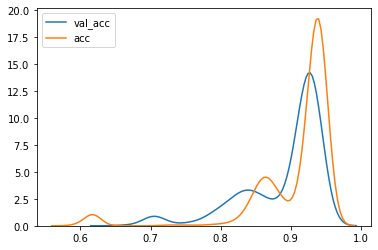

In [ ]:
import seaborn as sns
sns.kdeplot(df_pl['val_acc'])
sns.kdeplot(df_pl['acc'])

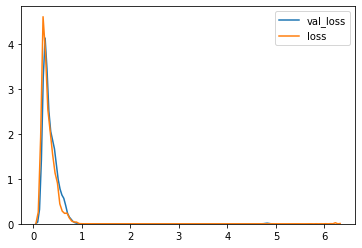

In [ ]:
sns.kdeplot(df_pl['val_loss'])
sns.kdeplot(df_pl['loss'])

In [ ]:
df_pl[df_pl['val_loss'] == min(df_pl['val_loss'])]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
23,23,15,0.172156,0.940586,0.687585,0.683078,0.731964,0.155214,0.947407,0.928358,0.937172,0.925596,32,30,"[20, 10, 5]",0.002,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."


In [ ]:
df_pl[df_pl['val_acc'] == min(df_pl['val_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
288,288,8,0.762838,0.662037,0.453148,0.542022,0.626835,0.624533,0.739074,0.630173,0.684919,0.595823,64,30,"[20, 10, 5]",0.0001,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7f0ab9b6e550>


In [ ]:
df_pl.sort_values('val_loss')[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
23,23,15,0.172156,0.940586,0.687585,0.683078,0.731964,0.155214,0.947407,0.928358,0.937172,0.925596,32,30,"[20, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
499,499,25,0.177773,0.938272,0.861846,0.818572,0.925851,0.158121,0.946852,0.929932,0.930063,0.931265,128,30,"[20, 10, 5]",0.0020,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
322,322,30,0.183380,0.931327,0.744648,0.732906,0.809308,0.172899,0.946481,0.929237,0.930348,0.932397,64,30,"[30, 10, 4]",0.0020,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
251,251,9,0.185513,0.933642,0.749341,0.734764,0.809804,0.165344,0.944074,0.926328,0.926415,0.929091,64,30,"[20, 10, 5]",0.0050,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
667,667,13,0.187427,0.941358,0.854389,0.846117,0.873762,0.169126,0.945370,0.928204,0.930948,0.927521,128,30,"[60, 30, 15, 5]",0.0050,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
35,35,30,0.187601,0.933642,0.675245,0.667960,0.724621,0.157538,0.949815,0.931784,0.933493,0.935207,32,30,"[20, 10, 5]",0.0005,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
483,483,9,0.189101,0.935957,0.843967,0.826717,0.890716,0.171286,0.942778,0.924675,0.924333,0.926806,128,30,"[20, 10, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
71,71,9,0.190765,0.926698,0.641868,0.708261,0.634597,0.171102,0.941481,0.920501,0.923837,0.924311,32,30,"[30, 10, 4]",0.0050,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
127,127,11,0.192211,0.934414,0.680451,0.670697,0.728575,0.180015,0.940185,0.918574,0.919402,0.924860,32,30,"[80, 40, 20, 10, 5]",0.0050,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
427,427,11,0.192732,0.938272,0.739212,0.768043,0.752590,0.173099,0.945556,0.927629,0.926217,0.932532,64,30,"[60, 30, 15, 5]",0.0050,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."


In [ ]:
df_pl.sort_values('val_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
657,657,30,0.381372,0.945988,0.868993,0.861828,0.885122,0.391883,0.929630,0.905974,0.912474,0.901835,128,30,"[80, 40, 20, 10, 5]",0.0001,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
174,174,30,0.285258,0.942901,0.682971,0.724904,0.687196,0.273376,0.939444,0.917356,0.921982,0.918645,32,30,"[80, 40, 20, 10, 5]",0.0001,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
269,269,30,0.245516,0.942130,0.758922,0.779649,0.778900,0.268847,0.937778,0.916828,0.921102,0.917416,64,30,"[20, 10, 5]",0.0005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
585,585,30,0.253958,0.942130,0.856450,0.832700,0.910853,0.263419,0.929074,0.906459,0.912127,0.902590,128,30,"[30, 10, 4]",0.0002,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
701,701,30,0.264574,0.941358,0.859362,0.852420,0.880217,0.258220,0.937593,0.917118,0.917476,0.918983,128,30,"[60, 30, 15, 5]",0.0002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
667,667,13,0.187427,0.941358,0.854389,0.846117,0.873762,0.169126,0.945370,0.928204,0.930948,0.927521,128,30,"[60, 30, 15, 5]",0.0050,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
103,103,17,0.217900,0.941358,0.692919,0.669765,0.751855,0.202289,0.941852,0.922788,0.928049,0.923522,32,30,"[30, 10, 4]",0.0002,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
331,331,30,0.200622,0.941358,0.762387,0.748749,0.801131,0.174060,0.950185,0.934353,0.930663,0.940784,64,30,"[30, 10, 4]",0.0005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
271,271,16,0.208263,0.941358,0.755646,0.729814,0.813667,0.191984,0.943333,0.925411,0.933043,0.920478,64,30,"[20, 10, 5]",0.0005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
223,223,30,0.248374,0.940586,0.690611,0.675223,0.738509,0.220172,0.949074,0.931288,0.932812,0.935381,32,30,"[60, 30, 15, 5]",0.0002,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."


In [ ]:
df_pl.sort_values('val_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
657,657,30,0.381372,0.945988,0.868993,0.861828,0.885122,0.391883,0.929630,0.905974,0.912474,0.901835,128,30,"[80, 40, 20, 10, 5]",0.0001,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
629,629,16,0.330557,0.940586,0.863996,0.816087,0.950474,0.313359,0.938704,0.919180,0.923067,0.918261,128,30,"[80, 40, 20, 10, 5]",0.0005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
689,689,25,0.284409,0.939043,0.862970,0.817880,0.948530,0.261402,0.939259,0.920187,0.923962,0.918741,128,30,"[60, 30, 15, 5]",0.0005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
499,499,25,0.177773,0.938272,0.861846,0.818572,0.925851,0.158121,0.946852,0.929932,0.930063,0.931265,128,30,"[20, 10, 5]",0.0020,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
675,675,19,0.214634,0.937500,0.860008,0.807669,0.926212,0.186091,0.946111,0.928900,0.928171,0.931716,128,30,"[60, 30, 15, 5]",0.0020,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
571,571,30,0.436991,0.939815,0.859662,0.817783,0.914271,0.382559,0.945185,0.928194,0.928791,0.929357,128,30,"[30, 10, 4]",0.0005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
545,545,29,0.217026,0.936728,0.859566,0.805768,0.956209,0.189904,0.935185,0.913290,0.925515,0.904727,128,30,"[30, 10, 4]",0.0050,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
701,701,30,0.264574,0.941358,0.859362,0.852420,0.880217,0.258220,0.937593,0.917118,0.917476,0.918983,128,30,"[60, 30, 15, 5]",0.0002,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
503,503,11,0.203964,0.935957,0.858861,0.806973,0.950080,0.170699,0.943704,0.926868,0.923401,0.931977,128,30,"[20, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
653,653,30,0.407544,0.937500,0.858381,0.821329,0.939965,0.398593,0.933704,0.912813,0.914881,0.912665,128,30,"[80, 40, 20, 10, 5]",0.0001,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)


In [ ]:
df_pl.sort_values('val_precision_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
534,534,30,0.423217,0.837963,0.526220,0.939040,0.395316,0.485645,0.844630,0.752791,0.954331,0.624978,128,30,"[20, 10, 5]",0.0001,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
669,669,11,0.327938,0.877315,0.650160,0.934491,0.523826,0.250717,0.926667,0.901495,0.914974,0.898944,128,30,"[60, 30, 15, 5]",0.0050,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
681,681,8,0.401138,0.875000,0.639009,0.927796,0.512916,0.306950,0.926296,0.902361,0.912261,0.903156,128,30,"[60, 30, 15, 5]",0.0020,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
489,489,7,0.308496,0.882716,0.656882,0.926150,0.540761,0.236518,0.922222,0.895591,0.904720,0.898847,128,30,"[20, 10, 5]",0.0050,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
665,665,9,0.340147,0.880401,0.649291,0.924123,0.528364,0.284427,0.926296,0.902132,0.906506,0.906610,128,30,"[60, 30, 15, 5]",0.0050,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
614,614,13,0.353627,0.880401,0.641684,0.917332,0.529345,0.238461,0.933519,0.911647,0.918507,0.912538,128,30,"[80, 40, 20, 10, 5]",0.0020,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
602,602,6,0.406734,0.858025,0.563020,0.911336,0.460807,0.267907,0.922037,0.892956,0.928726,0.874894,128,30,"[80, 40, 20, 10, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
674,674,5,0.481233,0.834105,0.513572,0.905574,0.398023,0.298724,0.916296,0.889044,0.902235,0.892411,128,30,"[60, 30, 15, 5]",0.0020,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
539,539,30,0.435493,0.854167,0.624858,0.893723,0.523940,0.429875,0.857963,0.789767,0.907566,0.702718,128,30,"[20, 10, 5]",0.0001,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
593,593,30,0.436770,0.930556,0.823784,0.887583,0.795959,0.476620,0.871111,0.811582,0.914556,0.732478,128,30,"[30, 10, 4]",0.0001,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)


In [ ]:
df_pl.sort_values('val_recall_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
590,590,30,0.668130,0.851852,0.762366,0.632190,0.997178,0.652083,0.819815,0.801121,0.690367,0.957424,128,30,"[30, 10, 4]",0.0001,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
662,662,9,0.434641,0.870370,0.772253,0.661023,0.994827,0.246282,0.925741,0.899770,0.919344,0.892348,128,30,"[60, 30, 15, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
502,502,8,0.351557,0.867284,0.771383,0.660076,0.994827,0.203825,0.933889,0.912454,0.914942,0.913624,128,30,"[20, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
609,609,12,0.639229,0.780864,0.684652,0.547585,0.994827,0.254329,0.924074,0.900564,0.909237,0.904687,128,30,"[80, 40, 20, 10, 5]",0.0050,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
549,549,6,0.416353,0.817901,0.716424,0.583758,0.994827,0.359006,0.897593,0.870545,0.875439,0.889821,128,30,"[30, 10, 4]",0.0050,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
553,553,10,0.562547,0.776235,0.682104,0.544338,0.994827,0.282114,0.913704,0.881300,0.904257,0.879693,128,30,"[30, 10, 4]",0.0020,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
542,542,15,0.334197,0.876543,0.781771,0.674706,0.994827,0.212925,0.932593,0.910186,0.917510,0.913728,128,30,"[30, 10, 4]",0.0050,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
501,501,14,0.387500,0.867284,0.768240,0.650315,0.994827,0.232452,0.927407,0.901241,0.920832,0.891951,128,30,"[20, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
670,670,5,0.399794,0.864969,0.766613,0.651325,0.994827,0.258885,0.926481,0.903768,0.914925,0.902920,128,30,"[60, 30, 15, 5]",0.0050,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
493,493,15,0.348733,0.875000,0.775288,0.666613,0.984009,0.249175,0.923889,0.897984,0.918852,0.890078,128,30,"[20, 10, 5]",0.0020,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)


### Latency

In [ ]:
# Grid options
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
p = {
    'scaler' : [IDScaler(), MaxAbsScaler(), MinMaxScaler(), StandardScaler()],
    'layers' : [[20,10,5],[30,10,4],[80,40,20,10,5],[60,30,15,5]],
    'epochs' : [30],
    'optimizer' : [RMSprop, Adam, Nadam],
    'lr' : [5e-3, 2e-3, 5e-4, 2e-4, 1e-4],
    'batch_size' : [32, 64, 128]
}

In [ ]:
import talos
y = y_la
t = talos.Scan(X[:25*nb_opts], y[:25*nb_opts],  # First 25 cycles -> train cycles
               x_val=X[25*nb_opts:], y_val=y[25*nb_opts:], # Last 5 cycles -> test cycles
               model=build_classfication_pipeline,
               params=p, experiment_name='la')

In [ ]:
t.data.to_csv('gridsearch_la_v1.csv')

In [ ]:
df_la = pd.read_csv('gridsearch_la_v1.csv')
df_la.head()

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
0,0,12,0.329416,0.894290,0.905668,0.936255,0.901847,0.316706,0.888889,0.932902,0.898988,0.973328,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7f0a43e882b0>
1,1,12,0.375582,0.879630,0.910992,0.862085,0.983248,0.277461,0.895556,0.934855,0.923511,0.950598,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
2,2,9,0.290663,0.895062,0.921658,0.885331,0.978946,0.282637,0.899630,0.938324,0.916652,0.964381,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
3,3,14,0.290142,0.912037,0.924027,0.928694,0.936577,0.297031,0.903889,0.940818,0.914032,0.971557,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
4,4,30,0.477499,0.817130,0.881092,0.817130,1.000000,0.497980,0.802778,0.889031,0.802778,1.000000,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f0a43e882b0>


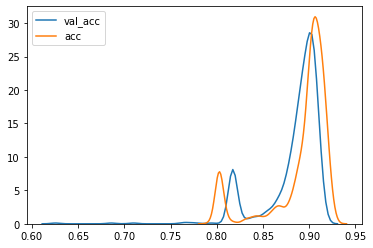

In [ ]:
import seaborn as sns
sns.kdeplot(df_la['val_acc'])
sns.kdeplot(df_la['acc'])

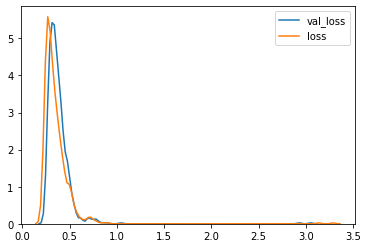

In [ ]:
sns.kdeplot(df_la['val_loss'])
sns.kdeplot(df_la['loss'])

In [ ]:
df_la[df_la['val_loss'] == min(df_la['val_loss'])]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
20,20,24,0.242458,0.91358,0.922432,0.937547,0.914449,0.241638,0.908889,0.94265,0.939803,0.948475,32,30,"[20, 10, 5]",0.002,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f0a43e882b0>


In [ ]:
df_la[df_la['val_acc'] == max(df_la['val_acc'])]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
15,15,13,0.273206,0.915895,0.92337,0.933965,0.927399,0.2501,0.910926,0.943625,0.940302,0.948861,32,30,"[20, 10, 5]",0.002,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."


In [ ]:
df_la.sort_values('val_loss')[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
20,20,24,0.242458,0.913580,0.922432,0.937547,0.914449,0.241638,0.908889,0.942650,0.939803,0.948475,32,30,"[20, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
210,210,20,0.246761,0.905093,0.923527,0.904950,0.957660,0.230174,0.908704,0.943572,0.919780,0.970848,32,30,"[60, 30, 15, 5]",0.0005,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
257,257,25,0.248819,0.905864,0.932782,0.913503,0.956492,0.253436,0.908704,0.943399,0.928415,0.960411,64,30,"[20, 10, 5]",0.0020,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
5,5,14,0.250840,0.905864,0.918893,0.906716,0.938461,0.263838,0.900556,0.937665,0.925250,0.953668,32,30,"[20, 10, 5]",0.0050,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
18,18,13,0.253070,0.905093,0.917170,0.912077,0.929478,0.234811,0.915741,0.947236,0.940594,0.956524,32,30,"[20, 10, 5]",0.0020,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
305,305,13,0.254853,0.910494,0.934227,0.935673,0.935356,0.257863,0.902963,0.939929,0.927513,0.955393,64,30,"[30, 10, 4]",0.0050,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
137,137,14,0.255626,0.907407,0.917530,0.913863,0.928988,0.253126,0.906667,0.941619,0.927741,0.959904,32,30,"[80, 40, 20, 10, 5]",0.0020,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
187,187,20,0.257361,0.897377,0.909265,0.904828,0.928965,0.227628,0.912037,0.944256,0.943757,0.947482,32,30,"[60, 30, 15, 5]",0.0050,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
630,630,30,0.257428,0.904321,0.934469,0.917033,0.954933,0.235713,0.915741,0.947977,0.937744,0.959335,128,30,"[80, 40, 20, 10, 5]",0.0005,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
132,132,8,0.259316,0.910494,0.928870,0.900639,0.971500,0.272500,0.892963,0.934343,0.909858,0.963696,32,30,"[80, 40, 20, 10, 5]",0.0020,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7f0a43e882b0>


In [ ]:
df_la.sort_values('val_acc',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
15,15,13,0.273206,0.915895,0.923370,0.933965,0.927399,0.250100,0.910926,0.943625,0.940302,0.948861,32,30,"[20, 10, 5]",0.0020,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
269,269,30,0.260780,0.915123,0.939632,0.925146,0.956809,0.275473,0.910185,0.945134,0.922687,0.969936,64,30,"[20, 10, 5]",0.0005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
176,176,30,0.357126,0.915123,0.923802,0.927070,0.928146,0.342116,0.910926,0.944227,0.933725,0.956776,32,30,"[80, 40, 20, 10, 5]",0.0001,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
513,513,30,0.325356,0.914352,0.942997,0.921729,0.969075,0.353132,0.894815,0.936939,0.903163,0.973947,128,30,"[20, 10, 5]",0.0005,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
107,107,30,0.328416,0.914352,0.928124,0.916305,0.956012,0.300399,0.912593,0.945478,0.930200,0.963772,32,30,"[30, 10, 4]",0.0002,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
149,149,22,0.307810,0.913580,0.922220,0.939609,0.913623,0.282624,0.916111,0.947127,0.941705,0.955173,32,30,"[80, 40, 20, 10, 5]",0.0005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
448,448,17,0.341969,0.913580,0.935166,0.943234,0.930365,0.329921,0.910185,0.944524,0.926972,0.964001,64,30,"[60, 30, 15, 5]",0.0005,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
20,20,24,0.242458,0.913580,0.922432,0.937547,0.914449,0.241638,0.908889,0.942650,0.939803,0.948475,32,30,"[20, 10, 5]",0.0020,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
436,436,18,0.335389,0.913580,0.940303,0.934818,0.950656,0.315996,0.902407,0.940684,0.912183,0.972669,64,30,"[60, 30, 15, 5]",0.0020,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
154,154,18,0.295868,0.913580,0.920996,0.939716,0.910903,0.255779,0.918519,0.948501,0.941077,0.958277,32,30,"[80, 40, 20, 10, 5]",0.0005,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"


In [ ]:
df_la.sort_values('val_f1_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
513,513,30,0.325356,0.914352,0.942997,0.921729,0.969075,0.353132,0.894815,0.936939,0.903163,0.973947,128,30,"[20, 10, 5]",0.0005,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
696,696,30,0.389528,0.912809,0.941222,0.930335,0.954649,0.370917,0.907407,0.943257,0.925166,0.962859,128,30,"[60, 30, 15, 5]",0.0002,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7f0a43e882b0>
609,609,14,0.331362,0.909722,0.940616,0.907503,0.979970,0.426339,0.845741,0.910106,0.856729,0.976976,128,30,"[80, 40, 20, 10, 5]",0.0050,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
648,648,30,0.433700,0.909722,0.940523,0.914146,0.973177,0.446612,0.902963,0.940990,0.917041,0.966791,128,30,"[80, 40, 20, 10, 5]",0.0001,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7f0a43e882b0>
436,436,18,0.335389,0.913580,0.940303,0.934818,0.950656,0.315996,0.902407,0.940684,0.912183,0.972669,64,30,"[60, 30, 15, 5]",0.0020,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
704,704,30,0.378600,0.908951,0.940146,0.905138,0.982390,0.408751,0.895741,0.936500,0.913762,0.960875,128,30,"[60, 30, 15, 5]",0.0002,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
637,637,30,0.400551,0.908951,0.939873,0.915453,0.970685,0.419640,0.890370,0.934500,0.894532,0.978971,128,30,"[80, 40, 20, 10, 5]",0.0002,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
269,269,30,0.260780,0.915123,0.939632,0.925146,0.956809,0.275473,0.910185,0.945134,0.922687,0.969936,64,30,"[20, 10, 5]",0.0005,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)
693,693,30,0.323627,0.908179,0.939611,0.905666,0.980296,0.335879,0.905926,0.942838,0.916211,0.971888,128,30,"[60, 30, 15, 5]",0.0005,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
485,485,16,0.268252,0.909722,0.939520,0.932464,0.950348,0.269089,0.908519,0.943668,0.927948,0.961117,128,30,"[20, 10, 5]",0.0050,<class 'keras.optimizers.Adam'>,MaxAbsScaler(copy=True)


In [ ]:
df_la.sort_values('val_precision_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
662,662,7,0.603727,0.685957,0.747217,0.996594,0.606351,0.313831,0.887407,0.930618,0.916470,0.948707,128,30,"[60, 30, 15, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
561,561,11,0.405772,0.870370,0.894087,0.980884,0.834249,0.332613,0.889259,0.931579,0.911202,0.957094,128,30,"[30, 10, 4]",0.0020,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
324,324,30,0.387590,0.863426,0.892039,0.978712,0.831843,0.268070,0.910370,0.944482,0.933071,0.957625,64,30,"[30, 10, 4]",0.0005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7f0a43e882b0>
680,680,28,0.331692,0.875000,0.903072,0.973072,0.850812,0.259663,0.905185,0.941723,0.921324,0.964411,128,30,"[60, 30, 15, 5]",0.0020,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
544,544,23,0.304080,0.882716,0.911151,0.971814,0.864342,0.262979,0.904630,0.940163,0.940613,0.941238,128,30,"[30, 10, 4]",0.0050,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
320,320,11,0.317321,0.890432,0.911026,0.969935,0.869929,0.305861,0.904074,0.940264,0.930006,0.952615,64,30,"[30, 10, 4]",0.0020,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
604,604,10,0.388884,0.889660,0.917307,0.968856,0.877496,0.358955,0.900000,0.938538,0.922001,0.957604,128,30,"[80, 40, 20, 10, 5]",0.0050,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
361,361,14,0.314789,0.868827,0.898484,0.967026,0.850759,0.296792,0.889815,0.931239,0.921836,0.945553,64,30,"[80, 40, 20, 10, 5]",0.0050,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
441,441,7,0.382136,0.888889,0.915016,0.965359,0.879201,0.344219,0.900556,0.938435,0.924424,0.956049,64,30,"[60, 30, 15, 5]",0.0020,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
375,375,14,0.402674,0.863426,0.895958,0.965176,0.846623,0.262228,0.917778,0.948581,0.945327,0.953311,64,30,"[80, 40, 20, 10, 5]",0.0020,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."


In [ ]:
df_la.sort_values('val_recall_m',ascending=False)[:10]

,Unnamed: 0,round_epochs,val_loss,val_acc,val_f1_m,val_precision_m,val_recall_m,loss,acc,f1_m,precision_m,recall_m,batch_size,epochs,layers,lr,optimizer,scaler
280,280,9,0.795604,0.81713,0.889690,0.81713,1.0,0.689711,0.802222,0.889413,0.802681,0.999328,64,30,"[20, 10, 5]",0.0002,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
537,537,30,0.519766,0.81713,0.892647,0.81713,1.0,0.542137,0.802778,0.890202,0.802778,1.000000,128,30,"[20, 10, 5]",0.0001,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
573,573,30,0.556781,0.81713,0.892647,0.81713,1.0,0.566268,0.802778,0.890218,0.802778,1.000000,128,30,"[30, 10, 4]",0.0005,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
116,116,30,0.619876,0.81713,0.881092,0.81713,1.0,0.628919,0.801852,0.888197,0.802664,0.998558,32,30,"[30, 10, 4]",0.0001,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
548,548,30,0.497341,0.81713,0.892647,0.81713,1.0,0.518070,0.802778,0.890229,0.802778,1.000000,128,30,"[30, 10, 4]",0.0050,<class 'keras.optimizers.Nadam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
52,52,4,0.764794,0.81713,0.881092,0.81713,1.0,0.782989,0.793889,0.882962,0.802142,0.986253,32,30,"[20, 10, 5]",0.0001,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f0a43e882b0>
129,129,22,0.479692,0.81713,0.881092,0.81713,1.0,0.500006,0.802778,0.888812,0.802778,1.000000,32,30,"[80, 40, 20, 10, 5]",0.0050,<class 'keras.optimizers.Nadam'>,MaxAbsScaler(copy=True)
130,130,12,0.482564,0.81713,0.881092,0.81713,1.0,0.500651,0.802778,0.889162,0.802778,1.000000,32,30,"[80, 40, 20, 10, 5]",0.0050,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
538,538,30,0.480127,0.81713,0.892647,0.81713,1.0,0.505236,0.803148,0.890380,0.803094,1.000000,128,30,"[20, 10, 5]",0.0001,<class 'keras.optimizers.Nadam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
534,534,30,0.506517,0.81713,0.892647,0.81713,1.0,0.532918,0.802778,0.890082,0.802778,1.000000,128,30,"[20, 10, 5]",0.0001,<class 'keras.optimizers.Adam'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"


## OPTIMIZATION - Grid search DNN

In [5]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler

class IDScaler:
    def fit(self, x):
        pass
    def partial_fit(self, x):
        pass
    def fit_transform(self, x):
        return x
    def transform(self, x):
        return x

# Fetch 100 cycles of data
nb_cycles = 30
dfs = []
nb_opts = len(construct_cycle_df(folder_path, 1))
for c in range(10,nb_cycles+10):
    df = construct_cycle_df(folder_path, c)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

# Get x features
def get_features(df):
    return np.array([np.hstack(row) for row in  df.drop(['energyconsumption', 'packetloss', 'latency'], axis=1).values])
X = get_features(df)

# Get y features
def get_qualities(df, quality):
    return np.array([q for q in df[quality].values])
y_pl = np.array(list(map(lambda x : x < 10, get_qualities(df, 'packetloss'))), dtype=int)
y_la = np.array(list(map(lambda x : x < 5, get_qualities(df, 'latency'))), dtype=int)
y_ec = get_qualities(df, 'energyconsumption')

# Use this data to train and split
print(X.shape)
print(y_pl.shape, y_la.shape, y_ec.shape)

(6480, 85)
(6480,) (6480,) (6480,)


In [ ]:
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import l2, l1
from talos.model.early_stopper import early_stopper

def build_regression_pipeline(x_train, y_train, x_val, y_val, params):
    callback=early_stopper(params['epochs'],monitor='val_loss',mode='moderate')

    model = Sequential()
    model.add(Dense(params['layers'][0], input_dim=85, activation='relu', kernel_regularizer=l1(0.0005)))
    model.add(Dropout(0.1))    
    for layer in params['layers'][1:]:
        model.add(Dense(layer, activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(Dense(1, kernel_regularizer=l2(0.0005)))
    model.compile(optimizer=params['optimizer'](lr=params['lr']), loss='mse')

    scaler = params['scaler']
    x_train = scaler.fit_transform(x_train)
    scaler.partial_fit(x_val)
    x_val = scaler.transform(x_val)

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    validation_data=[x_val, y_val],
                    callbacks=[callback],
                    verbose=False)

    return out, model

### Energy consumption

In [ ]:
# Grid options
from keras.optimizers import Adam, RMSprop, Adagrad, Nadam
p = {
    'scaler' : [IDScaler(), MaxAbsScaler(), MinMaxScaler(), StandardScaler()],
    'layers' : [[20,10,5],[30,10,4],[80,40,20,10,5],[60,30,15,5]],
    'epochs' : [30],
    'optimizer' : [RMSprop, Adam, Nadam],
    'lr' : [5e-3, 2e-3, 5e-4, 2e-4, 1e-4],
    'batch_size' : [32, 64, 128]
}

In [ ]:
import talos
y = y_ec
t = talos.Scan(X[:25*nb_opts], y[:25*nb_opts], # First 25 cycles -> train cycles
               x_val=X[25*nb_opts:], y_val=y[25*nb_opts:], # Last 5 cycles -> test cycles
               model=build_regression_pipeline,
               params=p, experiment_name='ec')

In [ ]:
t.data.to_csv('gridsearch_ec_v1.csv')

In [ ]:
df_ec = pd.read_csv('gridsearch_ec_v1.csv')
df_ec.head()

,Unnamed: 0,round_epochs,val_loss,loss,batch_size,epochs,layers,lr,optimizer,scaler
0,0,9,4.760832,1.102271,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,<__main__.IDScaler object at 0x7f6f58fcb9e8>
1,1,5,2.476949,0.339860,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)
2,2,8,2.105330,0.296774,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,"MinMaxScaler(copy=True, feature_range=(0, 1))"
3,3,30,0.016663,0.034878,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
4,4,4,1.367011,0.327677,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.Adam'>,<__main__.IDScaler object at 0x7f6f58fcb9e8>


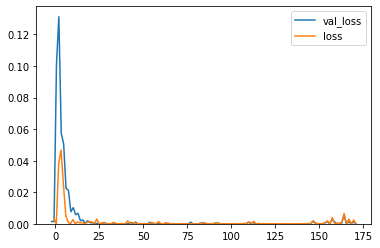

In [ ]:
import seaborn as sns
sns.kdeplot(df_ec['val_loss'])
sns.kdeplot(df_ec['loss'])

In [ ]:
df_ec[df_ec['val_loss'] == min(df_ec['val_loss'])]

,Unnamed: 0,round_epochs,val_loss,loss,batch_size,epochs,layers,lr,optimizer,scaler
3,3,30,0.016663,0.034878,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."


In [ ]:
df_ec.sort_values('val_loss')[:10]

,Unnamed: 0,round_epochs,val_loss,loss,batch_size,epochs,layers,lr,optimizer,scaler
3,3,30,0.016663,0.034878,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
127,127,30,0.023075,0.024718,32,30,"[80, 40, 20, 10, 5]",0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
63,63,30,0.023946,0.028943,32,30,"[30, 10, 4]",0.005,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
75,75,30,0.023951,0.019203,32,30,"[30, 10, 4]",0.002,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
15,15,29,0.025881,0.016257,32,30,"[20, 10, 5]",0.002,<class 'keras.optimizers.RMSprop'>,"StandardScaler(copy=True, with_mean=True, with..."
187,187,30,0.027500,0.029932,32,30,"[60, 30, 15, 5]",0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
191,191,30,0.028988,0.032114,32,30,"[60, 30, 15, 5]",0.005,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
11,11,30,0.029031,0.025722,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.Nadam'>,"StandardScaler(copy=True, with_mean=True, with..."
7,7,30,0.034528,0.030706,32,30,"[20, 10, 5]",0.005,<class 'keras.optimizers.Adam'>,"StandardScaler(copy=True, with_mean=True, with..."
121,121,19,0.039058,0.037988,32,30,"[80, 40, 20, 10, 5]",0.005,<class 'keras.optimizers.RMSprop'>,MaxAbsScaler(copy=True)


# Online simulation - v1

## Only threshold goals

In [ ]:
thresh = 0.5

In [ ]:
df_pl = pd.read_csv('df_pl_v1.csv')
df_pl = df_pl.rename(columns={'actual' : 'pl_goal', 'pred' : 'pl_pred'})
df_pl.head()

,Unnamed: 0,cycle,pl_pred,pl_goal
0,0,1,0.840015,1.0
1,1,1,0.869689,1.0
2,2,1,0.892672,1.0
3,3,1,0.911811,1.0
4,4,1,0.927814,1.0


In [ ]:
df_la = pd.read_csv('df_la_v1.csv')
df_la = df_la.rename(columns={'actual' : 'la_goal', 'pred' : 'la_pred'})
df_la.head()

,Unnamed: 0,cycle,la_pred,la_goal
0,0,1,0.960894,0.0
1,1,1,0.984001,1.0
2,2,1,0.994224,1.0
3,3,1,0.997928,1.0
4,4,1,0.999259,1.0


In [ ]:
reduction =  np.sum((df_pl['pl_pred'] > thresh)&(df_la['la_pred'] > thresh)) / len(df_pl)
print('Adaptation space reduction:')
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

Adaptation space reduction:
0.6441968525301859
Amount that we retain:
0.3558031474698141


In [ ]:
def f1(precision, recall):
    return 2 * precision * recall / (precision + recall)

In [ ]:
pred_combined_thresh = np.array((df_pl['pl_pred'] > thresh) & (df_la['la_pred'] > thresh)).astype(np.float16)
actual_combined_thresh = np.array((df_pl['pl_goal']) * (df_la['la_goal'])).astype(np.float16)
prec = precision(actual_combined_thresh, pred_combined_thresh)
rec = recall(actual_combined_thresh, pred_combined_thresh)
print('Precision:', prec)
print('Recall:', rec)
print('F1:', f1(prec, rec))

Precision: 0.8452409318691955
Recall: 0.870679496823115
F1: 0.8577716506528469


### Quality

In [ ]:
df['packetloss_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'packetloss_pred'] = df_pl['pl_pred']
df['latency_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'latency_pred'] = df_la['la_pred']
df['thresholds_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_pred'] = np.array((df_pl['pl_pred'] > thresh) & (df_la['la_pred'] > thresh)).astype(bool)
df['thresholds_goal'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_goal'] = np.array((df_pl['pl_goal']) * (df_la['la_goal'])).astype(bool)
df.head()

,energyconsumption,packetloss,latency,link0_distribution,link1_distribution,link2_distribution,link3_distribution,link4_distribution,link5_distribution,link6_distribution,link7_distribution,link8_distribution,link9_distribution,link10_distribution,link11_distribution,link12_distribution,link13_distribution,link14_distribution,link15_distribution,link16_distribution,env_EC,env_PL,env_LA,cycle,env_link0_dist,env_link1_dist,env_link2_dist,env_link3_dist,env_link4_dist,env_link5_dist,env_link6_dist,env_link7_dist,env_link8_dist,env_link9_dist,env_link10_dist,env_link11_dist,env_link12_dist,env_link13_dist,env_link14_dist,env_link15_dist,...,env_mote12_tl,env_mote13_tl,env_link0_snr,env_link1_snr,env_link2_snr,env_link3_snr,env_link4_snr,env_link5_snr,env_link6_snr,env_link7_snr,env_link8_snr,env_link9_snr,env_link10_snr,env_link11_snr,env_link12_snr,env_link13_snr,env_link14_snr,env_link15_snr,env_link16_snr,env_link0_power,env_link1_power,env_link2_power,env_link3_power,env_link4_power,env_link5_power,env_link6_power,env_link7_power,env_link8_power,env_link9_power,env_link10_power,env_link11_power,env_link12_power,env_link13_power,env_link14_power,env_link15_power,env_link16_power,packetloss_pred,latency_pred,thresholds_pred,thresholds_goal
0,12.7298,7.513370,2.909090,100,100,100,100,100,0,100,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,100,...,50,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0,0
1,12.7459,7.513370,0.763636,100,100,100,100,100,20,80,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,100,...,50,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0,0
2,12.7596,6.869435,0.000000,100,100,100,100,100,40,60,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,100,...,50,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0,0
3,12.7733,6.296525,0.000000,100,100,100,100,100,60,40,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,100,...,50,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0,0
4,12.7870,6.072190,1.251060,100,100,100,100,100,80,20,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,100,...,50,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0,0


#### Visualize the prediction

In [ ]:
import seaborn as sns
def visualize_threshold(sub_df):
    sns.set(font_scale=1.3)  # crazy big
    plt.figure(figsize=(10,6))
    g = sns.scatterplot(x='packetloss', y='latency', data=sub_df, hue='thresholds_pred', s=85)
    plt.plot([10, 10],[0,5], color='red', linewidth=3)
    plt.plot([0, 10],[5,5], color='red',  linewidth=3)#, size=5)
    plt.xlabel('Packet loss', fontsize=15)
    plt.ylabel('Latency', fontsize=15)
    plt.tight_layout()

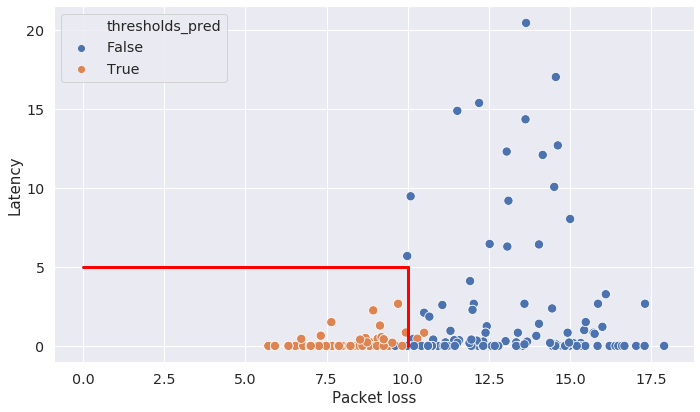

In [ ]:
cycle = 31 # 27
sub_df = df[df.cycle == nb_learnig_cycles + cycle]
visualize_threshold(sub_df)

#### Select the best adaptation option in the reduced adaptation space




In [ ]:
best_opt_reduced = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_pred == True] # The reduced adaptation space by using prediction
    sub_df = sub_df[sub_df.thresholds_goal == True] # Since all of the reduced options will be verified
    best_opt = None
    if len(sub_df) > 0:
        best_opt = sub_df[sub_df.energyconsumption == min(sub_df.energyconsumption)].iloc[0]
    best_opt_reduced.append(best_opt)

In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 20


,EC_reduced,PL_reduced,LA_reduced
6,12.8305,6.897825,0.00000
46,12.9608,7.155220,0.00000
0,12.7031,6.103530,1.00000
71,12.9870,8.034685,1.81818
0,12.8717,7.753560,1.81818


#### Select the best adaptation option in the complete adaptation space

In [ ]:
best_opts = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_goal == True] # The reduced adaptation space by using verification
    best_opt = None
    if len(sub_df) > 0:
        best_opt = sub_df[sub_df.energyconsumption == min(sub_df.energyconsumption)].iloc[0]
    best_opts.append(best_opt)

In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opts])
print('Nb of Nones:', nb_nones)
best_opts = [el for el in best_opts if el is not None ]
df_best_opts = pd.DataFrame(best_opts, columns=df.columns)
df_best_opts = df_best_opts[['energyconsumption', 'packetloss', 'latency']]
df_best_opts = df_best_opts.rename(columns={'energyconsumption' : 'EC_complete', 'packetloss' : 'PL_complete', 'latency': 'LA_complete'})
df_best_opts.head()

Nb of Nones: 12


,EC_complete,PL_complete,LA_complete
6,12.8305,6.897825,0.00000
46,12.9608,7.155220,0.00000
0,12.7031,6.103530,1.00000
71,12.9870,8.034685,1.81818
36,12.8660,8.960050,4.30556


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts])
combined_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,EC_complete,EC_reduced,LA_complete,LA_reduced,PL_complete,PL_reduced
6,NaN,12.8305,NaN,0.00000,NaN,6.897825
46,NaN,12.9608,NaN,0.00000,NaN,7.155220
0,NaN,12.7031,NaN,1.00000,NaN,6.103530
71,NaN,12.9870,NaN,1.81818,NaN,8.034685
0,NaN,12.8717,NaN,1.81818,NaN,7.753560


#### Compare quality

In [ ]:
print(np.mean(combined_df['EC_complete']))
print(np.mean(combined_df['EC_reduced']))

12.7236816091954
12.726821343873516


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=13698.0, pvalue=0.1505174725269137)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=5917.0, pvalue=0.9274039398610001)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=14795.0, pvalue=0.644268632179141)


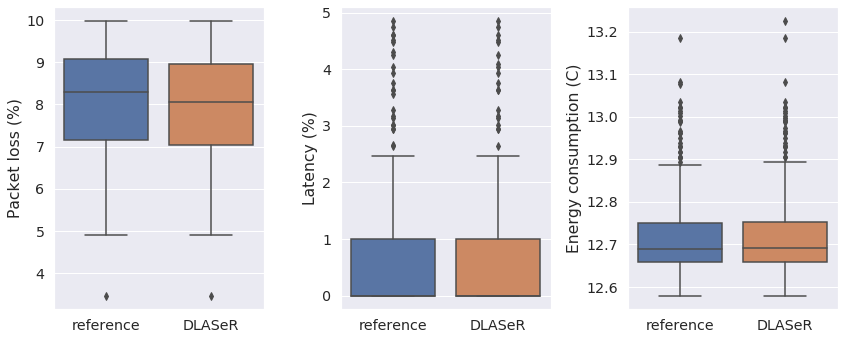

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(12,5))

plt.subplot(1,3,1)
combined_df = combined_df.rename(columns={'PL_complete' : 'reference', 'PL_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'PL_complete', 'DLASeR' : 'PL_reduced'})
plt.ylabel('Packet loss (%)')

plt.subplot(1,3,2)
combined_df = combined_df.rename(columns={'LA_complete' : 'reference', 'LA_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'LA_complete', 'DLASeR' : 'LA_reduced'})
plt.ylabel('Latency (%)')

plt.subplot(1,3,3)
combined_df = combined_df.rename(columns={'EC_complete' : 'reference', 'EC_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'EC_complete', 'DLASeR' : 'EC_reduced'})
plt.ylabel('Energy consumption (C)')

plt.tight_layout()

## Only an optimization goal

In [ ]:
thresh = 0.5

In [ ]:
df_pl = pd.read_csv('df_pl_v1.csv')
df_pl = df_pl.rename(columns={'actual' : 'pl_goal', 'pred' : 'pl_pred'})
df_pl.head()

,Unnamed: 0,cycle,pl_pred,pl_goal
0,0,1,0.840015,1.0
1,1,1,0.869689,1.0
2,2,1,0.892672,1.0
3,3,1,0.911811,1.0
4,4,1,0.927814,1.0


In [ ]:
df_la = pd.read_csv('df_la_v1.csv')
df_la = df_la.rename(columns={'actual' : 'la_goal', 'pred' : 'la_pred'})
df_la.head()

,Unnamed: 0,cycle,la_pred,la_goal
0,0,1,0.960894,0.0
1,1,1,0.984001,1.0
2,2,1,0.994224,1.0
3,3,1,0.997928,1.0
4,4,1,0.999259,1.0


In [ ]:
df_ec = pd.read_csv('df_ec_v1.csv')
df_ec = df_ec.rename(columns={'actual' : 'ec', 'pred' : 'ec_pred'})
df_ec.head()

,Unnamed: 0,cycle,ec_pred,ec
0,0,1,13.047025,12.9070
1,1,1,13.053710,12.9536
2,2,1,13.060395,12.9983
3,3,1,13.067080,12.9115
4,4,1,13.073765,12.9306


### Quality

In [ ]:
df['energyconsumption_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'energyconsumption_pred'] = df_ec['ec_pred']

#### Select the best adaptation option in the reduced adaptation space




In [ ]:
best_opt_reduced = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    cycle_idx = list(np.argsort(sub_df['energyconsumption_pred']))
    best_opt = None
    count = 0
    while best_opt is None and count < len(cycle_idx):
        idx = cycle_idx[count]
        if all(sub_df.iloc[[idx]]['packetloss'] < 10) and all(sub_df.iloc[[idx]]['latency'] < 5):
            best_opt = sub_df.iloc[idx]
        count +=1
    best_opt_reduced.append(best_opt)

In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 12


,EC_reduced,PL_reduced,LA_reduced
10,12.8305,6.897825,0.000000
20,13.0532,5.248465,0.757143
10,12.7347,6.753660,0.000000
15,13.0396,5.427085,1.590910
10,12.9453,8.337230,2.405910


#### Select the best adaptation option in the complete adaptation space

In [ ]:
best_opts = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_goal == True] # The reduced adaptation space by using verification
    best_opt = None
    if len(sub_df) > 0:
        best_opt = sub_df[sub_df.energyconsumption == min(sub_df.energyconsumption)].iloc[0]
    best_opts.append(best_opt)

In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opts])
print('Nb of Nones:', nb_nones)
best_opts = [el for el in best_opts if el is not None ]
df_best_opts = pd.DataFrame(best_opts, columns=df.columns)
df_best_opts = df_best_opts[['energyconsumption', 'packetloss', 'latency']]
df_best_opts = df_best_opts.rename(columns={'energyconsumption' : 'EC_complete', 'packetloss' : 'PL_complete', 'latency': 'LA_complete'})
df_best_opts.head()

Nb of Nones: 12


,EC_complete,PL_complete,LA_complete
6,12.8305,6.897825,0.00000
46,12.9608,7.155220,0.00000
0,12.7031,6.103530,1.00000
71,12.9870,8.034685,1.81818
36,12.8660,8.960050,4.30556


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




#### Compare quality

In [ ]:
print(np.mean(combined_df['EC_complete']))
print(np.mean(combined_df['EC_reduced']))

12.7236816091954
12.763420689655177


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=4184.0, pvalue=8.455304466431908e-10)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=1758.5, pvalue=1.7428798155697245e-05)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=0.0, pvalue=1.3325742527597178e-32)


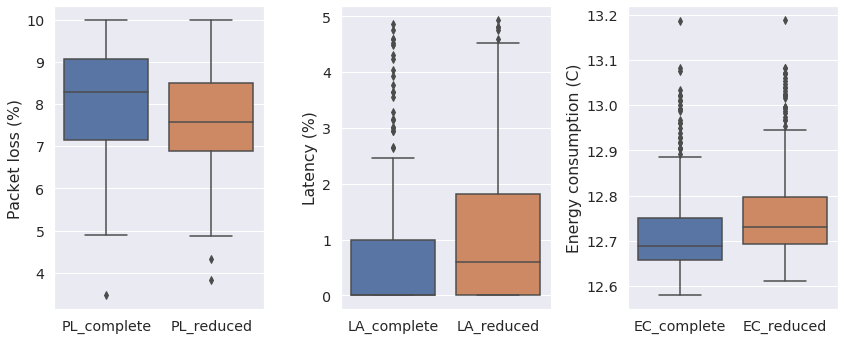

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(12,5))

plt.subplot(1,3,1)
sns.boxplot(data=combined_df[['PL_complete', 'PL_reduced']])
plt.ylabel('Packet loss (%)')

plt.subplot(1,3,2)
sns.boxplot(data=combined_df[['LA_complete', 'LA_reduced']])
plt.ylabel('Latency (%)')

plt.subplot(1,3,3)
sns.boxplot(data=combined_df[['EC_complete', 'EC_reduced']])
plt.ylabel('Energy consumption (C)')

plt.tight_layout()

## Both threshold goals and 1 optimization goal

In [ ]:
thresh = 0.5

In [ ]:
df_pl = pd.read_csv('df_pl_v1.csv')
df_pl = df_pl.rename(columns={'actual' : 'pl_goal', 'pred' : 'pl_pred'})
df_pl.head()

,Unnamed: 0,cycle,pl_pred,pl_goal
0,0,1,0.840015,1.0
1,1,1,0.869689,1.0
2,2,1,0.892672,1.0
3,3,1,0.911811,1.0
4,4,1,0.927814,1.0


In [ ]:
df_la = pd.read_csv('df_la_v1.csv')
df_la = df_la.rename(columns={'actual' : 'la_goal', 'pred' : 'la_pred'})
df_la.head()

,Unnamed: 0,cycle,la_pred,la_goal
0,0,1,0.960894,0.0
1,1,1,0.984001,1.0
2,2,1,0.994224,1.0
3,3,1,0.997928,1.0
4,4,1,0.999259,1.0


In [ ]:
reduction =  np.sum((df_pl['pl_pred'] > thresh)&(df_la['la_pred'] > thresh)) / len(df_pl)
print('Adaptation space reduction:')
print(1 - reduction)
print('Amount that we retain:')
print(reduction)

Adaptation space reduction:
0.6441968525301859
Amount that we retain:
0.3558031474698141


In [ ]:
df_ec = pd.read_csv('df_ec_v1.csv')
df_ec = df_ec.rename(columns={'actual' : 'ec', 'pred' : 'ec_pred'})
df_ec.head()

,Unnamed: 0,cycle,ec_pred,ec
0,0,1,13.047025,12.9070
1,1,1,13.053710,12.9536
2,2,1,13.060395,12.9983
3,3,1,13.067080,12.9115
4,4,1,13.073765,12.9306


In [ ]:
df['packetloss_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'packetloss_pred'] = df_pl['pl_pred']
df['latency_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'latency_pred'] = df_la['la_pred']
df['energyconsumption_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'energyconsumption_pred'] = df_ec['ec_pred']

In [ ]:
nb_verifications = []
nones = 0
start_cycle = nb_learnig_cycles + 1
for c in range(start_cycle, max(df.cycle)):
    cycle_df = df[df.cycle == c]
    cycle_idx = np.argsort(cycle_df['energyconsumption_pred'])
    nb_count = 0
    count = 0
    valid = False
    while not valid and count < nb_opts:
        idx = cycle_idx[count]
        if all(cycle_df.iloc[[idx]]['packetloss_pred'] < 10) and all(cycle_df.iloc[[idx]]['latency_pred'] < 5):
            if all(cycle_df.iloc[[idx]]['packetloss'] < 10) and all(cycle_df.iloc[[idx]]['latency'] < 5):
                valid = True
            nb_count +=1
        count += 1
    if not valid:
        nones += 1
    nb_verifications.append(nb_count)

Without adjusting for NONE (thus cycles without any feasible solution)



In [ ]:
print('Adaptation space reduction:')
print(1 - np.sum(nb_verifications)/len(df_pl))
print('Amount that we retain:')
print(np.sum(nb_verifications)/len(df_pl))

Adaptation space reduction:
0.9480565730565731
Amount that we retain:
0.05194342694342694


In [ ]:
print('Adaptation space reduction:')
print(1 - (np.sum(nb_verifications) - nones*nb_opts)/len(df_pl))
print('Amount that we retain:')
print((np.sum(nb_verifications) - nones*nb_opts)/len(df_pl))

Adaptation space reduction:
0.992012617012617
Amount that we retain:
0.007987382987382987


### Quality

In [ ]:
df['packetloss_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'packetloss_pred'] = df_pl['pl_pred']
df['latency_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'latency_pred'] = df_la['la_pred']
df['energyconsumption_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'energyconsumption_pred'] = df_ec['ec_pred']

df['thresholds_pred'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_pred'] = np.array((df_pl['pl_pred'] > thresh) & (df_la['la_pred'] > thresh)).astype(bool)
df['thresholds_goal'] = 0
df.loc[df.cycle > nb_learnig_cycles + 1, 'thresholds_goal'] = np.array((df_pl['pl_goal']) * (df_la['la_goal'])).astype(bool)
df.head()

,energyconsumption,packetloss,latency,link0_distribution,link1_distribution,link2_distribution,link3_distribution,link4_distribution,link5_distribution,link6_distribution,link7_distribution,link8_distribution,link9_distribution,link10_distribution,link11_distribution,link12_distribution,link13_distribution,link14_distribution,link15_distribution,link16_distribution,env_EC,env_PL,env_LA,cycle,verification_time,env_link0_dist,env_link1_dist,env_link2_dist,env_link3_dist,env_link4_dist,env_link5_dist,env_link6_dist,env_link7_dist,env_link8_dist,env_link9_dist,env_link10_dist,env_link11_dist,env_link12_dist,env_link13_dist,env_link14_dist,...,env_mote13_tl,env_link0_snr,env_link1_snr,env_link2_snr,env_link3_snr,env_link4_snr,env_link5_snr,env_link6_snr,env_link7_snr,env_link8_snr,env_link9_snr,env_link10_snr,env_link11_snr,env_link12_snr,env_link13_snr,env_link14_snr,env_link15_snr,env_link16_snr,env_link0_power,env_link1_power,env_link2_power,env_link3_power,env_link4_power,env_link5_power,env_link6_power,env_link7_power,env_link8_power,env_link9_power,env_link10_power,env_link11_power,env_link12_power,env_link13_power,env_link14_power,env_link15_power,env_link16_power,packetloss_pred,latency_pred,energyconsumption_pred,thresholds_pred,thresholds_goal
0,12.7298,7.513370,2.909090,100,100,100,100,100,0,100,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,144,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0.0,0,0
1,12.7459,7.513370,0.763636,100,100,100,100,100,20,80,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,124,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0.0,0,0
2,12.7596,6.869435,0.000000,100,100,100,100,100,40,60,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,100,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0.0,0,0
3,12.7733,6.296525,0.000000,100,100,100,100,100,60,40,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,94,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0.0,0,0
4,12.7870,6.072190,1.251060,100,100,100,100,100,80,20,100,100,0,100,100,0,100,100,100,100,16.283466,6.338028,0.0,1,88,100,100,100,100,100,50,50,100,100,50,50,100,50,50,100,...,100,3.285621,4.344321,-0.077079,-1.467279,-4.882079,1.666621,-2.236979,3.468421,0.761221,0.619921,2.315321,3.136021,-6.704479,3.124521,1.141021,-1.816879,-2.716579,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,0.0,0.0,0.0,0,0


#### Visualize the prediction

In [ ]:
import seaborn as sns
def visualize_optimization(sub_df):
    sns.set(font_scale=1.3)  # crazy big
    plt.subplots(2,1, figsize=(13,12))

    pal = 'copper_r'

    plt.subplot(2,1,1)
    g = sns.scatterplot(x='packetloss', y='energyconsumption', data=sub_df, hue='energyconsumption_pred', s=85, legend=False, palette=pal)
    plt.plot([10, 10],[min(sub_df['energyconsumption']) - 0.05, max(sub_df['energyconsumption']) + 0.05], color='red', linewidth=3)
    plt.xlabel('Packet loss', fontsize=15)
    plt.ylabel('Energy consumption', fontsize=15)
    norm = plt.Normalize(min(sub_df['energyconsumption']), max(sub_df['energyconsumption']))
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    g.figure.colorbar(sm)

    plt.subplot(2,1,2)
    g = sns.scatterplot(x='latency', y='energyconsumption', data=sub_df, hue='energyconsumption_pred', s=85, legend=False, palette=pal)
    plt.plot([5, 5],[min(sub_df['energyconsumption']) - 0.05, max(sub_df['energyconsumption']) + 0.05], color='red', linewidth=3)
    plt.xlabel('Latency', fontsize=15)
    plt.ylabel('Energy consumption', fontsize=15)
    norm = plt.Normalize(min(sub_df['energyconsumption']), max(sub_df['energyconsumption']))
    sm = plt.cm.ScalarMappable(cmap=pal, norm=norm)
    sm.set_array([])
    g.figure.colorbar(sm)

    plt.tight_layout()

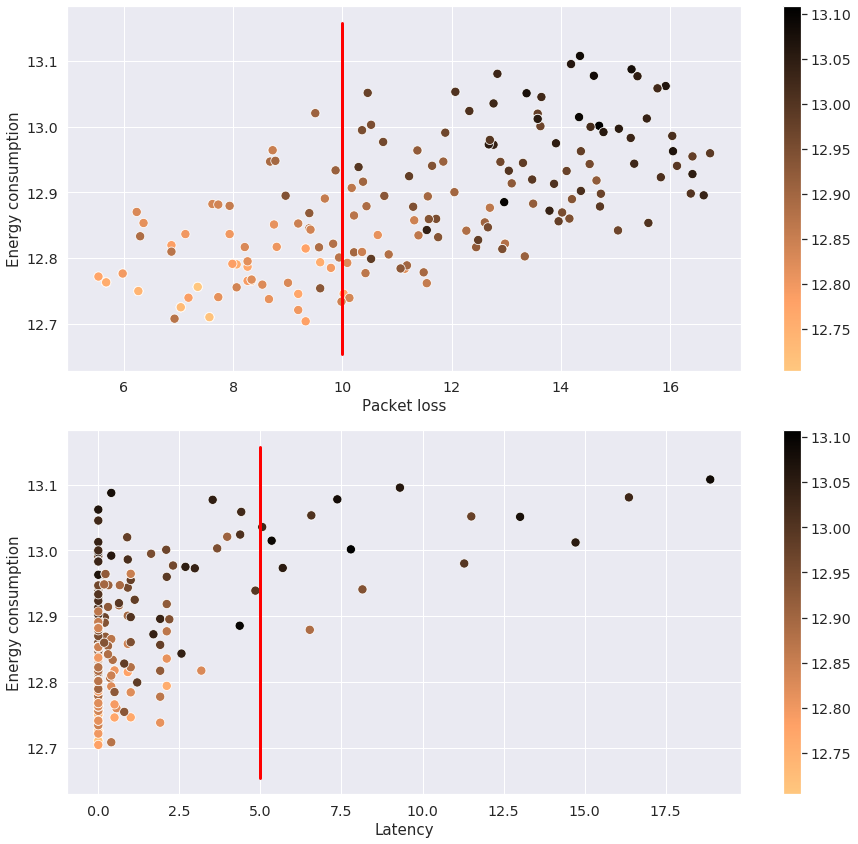

In [ ]:
cycle = 27
sub_df = df[df.cycle == nb_learnig_cycles + cycle]
visualize_optimization(sub_df)

#### Select the best adaptation option in the reduced adaptation space




In [ ]:
best_opt_reduced = []
reduced_verification_times = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_pred == True] # The reduced adaptation space by using prediction
    cycle_idx = list(np.argsort(sub_df['energyconsumption_pred']))
    best_opt = None
    count = 0
    while best_opt is None and count < len(cycle_idx):
        idx = cycle_idx[count]
        if all(sub_df.iloc[[idx]]['packetloss'] < 10) and all(sub_df.iloc[[idx]]['latency'] < 5):
            best_opt = sub_df.iloc[idx]
        reduced_verification_times.append(sub_df.iloc[idx]['verification_time'])
        count +=1
    best_opt_reduced.append(best_opt)

In [ ]:
print(len(reduced_verification_times))
print(np.sum(reduced_verification_times))
reduced_time = np.sum(reduced_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000
print(reduced_time, 'seconds')
print((np.sum(total_verification_times) - np.sum(reduced_verification_times)) / (nb_tot_cycles - (nb_learnig_cycles + 2)) * 0.05 / 1000 + reduced_time, 'seconds')

656
85366
0.31269597069597066 seconds
1.7848225274725273 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opt_reduced])
print('Nb of Nones:', nb_nones)
best_opt_reduced = [el for el in best_opt_reduced if el is not None ]
df_best_opt_reduced = pd.DataFrame(best_opt_reduced, columns=df.columns)
df_best_opt_reduced = df_best_opt_reduced[['energyconsumption', 'packetloss', 'latency']]
df_best_opt_reduced = df_best_opt_reduced.rename(columns={'energyconsumption' : 'EC_reduced', 'packetloss' : 'PL_reduced', 'latency': 'LA_reduced'})
df_best_opt_reduced.head()

Nb of Nones: 20


,EC_reduced,PL_reduced,LA_reduced
10,12.8305,6.897825,0.000000
20,13.0532,5.248465,0.757143
10,12.7347,6.753660,0.000000
15,13.0396,5.427085,1.590910
15,12.9979,8.212225,1.250000


#### Select the best adaptation option in the complete adaptation space

In [ ]:
best_opts = []
for c in range(nb_learnig_cycles + 2, nb_tot_cycles):
    sub_df = df[df.cycle == c]
    sub_df = sub_df[sub_df.thresholds_goal == True] # The reduced adaptation space by using verification
    best_opt = None
    if len(sub_df) > 0:
        best_opt = sub_df[sub_df.energyconsumption == min(sub_df.energyconsumption)].iloc[0]
    best_opts.append(best_opt)

In [ ]:
total_verification_times = df[(df.cycle >= nb_learnig_cycles + 2) & (df.cycle < nb_tot_cycles)]['verification_time']
print(len(total_verification_times))
print(np.sum(total_verification_times))
print(np.sum(total_verification_times) / (nb_tot_cycles - (nb_learnig_cycles + 2)) / 1000, 'seconds')

58968
8123177
29.755227106227107 seconds


In [ ]:
nb_nones = sum([1 if el is None else 0 for el in best_opts])
print('Nb of Nones:', nb_nones)
best_opts = [el for el in best_opts if el is not None ]
df_best_opts = pd.DataFrame(best_opts, columns=df.columns)
df_best_opts = df_best_opts[['energyconsumption', 'packetloss', 'latency']]
df_best_opts = df_best_opts.rename(columns={'energyconsumption' : 'EC_complete', 'packetloss' : 'PL_complete', 'latency': 'LA_complete'})
df_best_opts.head()

Nb of Nones: 12


,EC_complete,PL_complete,LA_complete
6,12.8305,6.897825,0.00000
46,12.9608,7.155220,0.00000
0,12.7031,6.103530,1.00000
71,12.9870,8.034685,1.81818
36,12.8660,8.960050,4.30556


In [ ]:
combined_df = pd.concat([df_best_opt_reduced, df_best_opts])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




#### Compare quality

In [ ]:
print(np.mean(combined_df['EC_complete']))
print(np.mean(combined_df['EC_reduced']))

12.7236816091954
12.767106719367591


In [ ]:
from scipy.stats import wilcoxon
print('Packet loss')
print(wilcoxon(df_best_opt_reduced['PL_reduced'], df_best_opts['PL_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Latency')
print(wilcoxon(df_best_opt_reduced['LA_reduced'], df_best_opts['LA_complete'][:len(df_best_opt_reduced)]))
print('-'*60)
print('Energy consumption')
print(wilcoxon(df_best_opt_reduced['EC_reduced'], df_best_opts['EC_complete'][:len(df_best_opt_reduced)]))

Packet loss
WilcoxonResult(statistic=10392.0, pvalue=2.497934283299184e-06)
------------------------------------------------------------
Latency
WilcoxonResult(statistic=5705.5, pvalue=0.004149699323901906)
------------------------------------------------------------
Energy consumption
WilcoxonResult(statistic=8857.5, pvalue=9.716868805306276e-10)


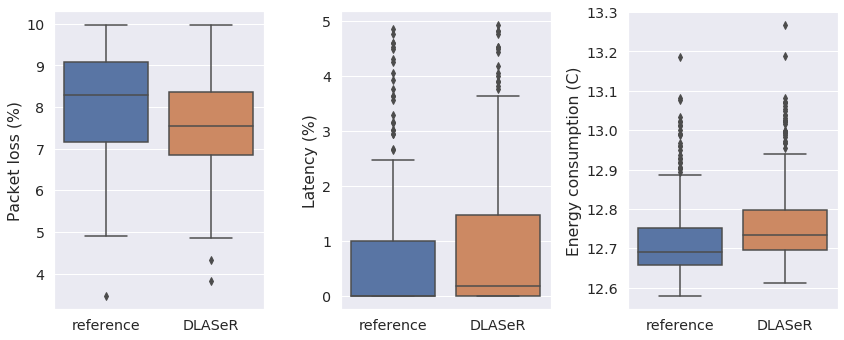

In [ ]:
import seaborn as sns

sns.set(font_scale=1.3)  # crazy big
plt.subplots(1,3, figsize=(12,5))

plt.subplot(1,3,1)
combined_df = combined_df.rename(columns={'PL_complete' : 'reference', 'PL_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'PL_complete', 'DLASeR' : 'PL_reduced'})
plt.ylabel('Packet loss (%)')

plt.subplot(1,3,2)
combined_df = combined_df.rename(columns={'LA_complete' : 'reference', 'LA_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'LA_complete', 'DLASeR' : 'LA_reduced'})
plt.ylabel('Latency (%)')

plt.subplot(1,3,3)
combined_df = combined_df.rename(columns={'EC_complete' : 'reference', 'EC_reduced' : 'DLASeR'})
sns.boxplot(data=combined_df[['reference', 'DLASeR']])
combined_df = combined_df.rename(columns={'reference' : 'EC_complete', 'DLASeR' : 'EC_reduced'})
plt.ylabel('Energy consumption (C)')

plt.tight_layout()